# Violation of Baccari et al.'s Bell inequality for path graphs from size 2 to 57 on IBM Quantum Brooklyn

In [5]:
import sys
import numpy as np
import pickle
import pprint

In [2]:
import qiskit
from qiskit import Aer, IBMQ
from qiskit.ignis.mitigation.measurement import TensoredMeasFitter

In [3]:
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q-utokyo', group='internal', project='hirashi-jst')
backend = provider.get_backend("ibmq_brooklyn")
simulator = Aer.get_backend("qasm_simulator")
device = provider.backends.ibmq_brooklyn

/var/folders/vr/d82vcp297v78vk4sb0_nzzdc0000gn/T/ipykernel_42334/4025133605.py:5: DeprecationWarning: The `backends` provider attribute is deprecated. Please use `provider.backend` (singular) instead. You can continue to use `provider.backends()` to retrieve all backends.
  device = provider.backends.ibmq_brooklyn


In [6]:
sys.path.append("../libs/")
from lib_graph_states import adjacency_list_for_path_graph, list_to_matrix
vertex_list = [11, 17, 18, 19, 25,
               33, 32, 31, 39, 45,
               46, 47, 48, 49, 40,
               35, 36, 37, 26, 23,
               22, 21, 12,  8,  7,
                6,  5,  4,  3,  2,
                1,  0, 10, 13, 14,
               15, 24, 29, 28, 27,
               38, 41, 42, 43, 52,
               56, 57, 58, 59, 60,
               61, 62, 63, 64, 54,
               51, 50] # 57 qubits # simulator
max_size = len(vertex_list) # largest graph size
initial_layouts = [vertex_list[:n] for n in range(1, max_size + 1)] # initial_layouts
F_list = [3 * i + 1 for i in range(max_size // 3)] # subset of focused vertices of graph size max_size
Fs = [F_list[:(n+1) // 3] for n in range(1, max_size + 1)] # subsets of focused vertices of graph size 1 to max_size
adj_lists = [adjacency_list_for_path_graph(n) for n in range(1, max_size + 1)] # adjacency list of graph size 1 to max_size
graphs = [list_to_matrix(adj_list) for adj_list in adj_lists] # adjacency matrix of graph size 1 to max_size
shots_per_circuit = 1 << 13 # shots per one execution

In [7]:
print("max_size:", max_size)
print("shots_per_circuit:", shots_per_circuit)
print("F_list:", F_list)
print("lengths of initial_layout:", [len(i) for i in initial_layouts])
pprint.pprint(initial_layouts[:10])

max_size: 57
shots_per_circuit: 8192
F_list: [1, 4, 7, 10, 13, 16, 19, 22, 25, 28, 31, 34, 37, 40, 43, 46, 49, 52, 55]
lengths of initial_layout: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57]
[[11],
 [11, 17],
 [11, 17, 18],
 [11, 17, 18, 19],
 [11, 17, 18, 19, 25],
 [11, 17, 18, 19, 25, 33],
 [11, 17, 18, 19, 25, 33, 32],
 [11, 17, 18, 19, 25, 33, 32, 31],
 [11, 17, 18, 19, 25, 33, 32, 31, 39],
 [11, 17, 18, 19, 25, 33, 32, 31, 39, 45]]


In [12]:
import importlib
import lib_preprocessing
importlib.reload(lib_preprocessing)
from lib_preprocessing import *

In [14]:
with open("../pkls/brooklyn_path.pkl", "rb") as f:
     job_ids = pickle.load(f)
results_jobs_list = job_ids_to_result(job_ids, device)
print("length of results_jobs_list: ", len(results_jobs_list))
results_list = flatten_results_jobs_list(results_jobs_list)
print("length of results_list: ", len(results_list))
# del results_jobs_list
results_graph_states, results_meas_cal = arrange_results_list_tensored(results_list)
print("length of results_meas_cal: ", len(results_meas_cal))
# del results_list

length of results_jobs_list:  1
length of results_list:  224
length of results_meas_cal:  56


In [15]:
counts_dict_list = results_list_to_counts_dict_list(results_graph_states)
print("length of counts_dict_list: ", len(counts_dict_list))
# del results_graph_states

length of counts_dict_list:  112


In [16]:
tensored_meas_mitigator_list = []
for n in range(2, max_size + 1):
    qr = qiskit.QuantumRegister(n)
    mit_pattern = [[i] for i in range(n)]
    meas_fitter = TensoredMeasFitter(results_meas_cal[n - 2], mit_pattern=mit_pattern)
    tensored_meas_mitigator_list.append( meas_fitter.filter )
print("length of tensored_meas_mitigator_list: ", len(tensored_meas_mitigator_list))
# del results_meas_cal

length of tensored_meas_mitigator_list:  56


In [18]:
# without QREM
from lib_path_graphs import analyze_circuits_tensored
corr_list_real, stddev_list_real, Es_list_real, Ds_list_real = analyze_circuits_tensored(adj_lists, Fs, counts_dict_list)

graph size: 1
skipped

graph size: 2
1.9073486328125e-06 s
9.5367431640625e-07 s
correlation on n[ 1 ]: 1.74365234375
correlation on remaining vertices: 0
total correlation: 2.4658967925948843 

graph size: 3
9.5367431640625e-07 s
1.9073486328125e-06 s
correlation on n[ 1 ]: 3.23828125
correlation on remaining vertices: 0
total correlation: 4.5796212625285 

graph size: 4
2.1457672119140625e-06 s
2.86102294921875e-06 s
correlation on n[ 1 ]: 3.217529296875
correlation on remaining vertices: 0.83349609375
total correlation: 5.3837696627233935 

graph size: 5
9.5367431640625e-07 s
1.1920928955078125e-06 s
correlation on n[ 1 ]: 3.224853515625
correlation on n[ 4 ]: 1.75390625
correlation on remaining vertices: 0
total correlation: 7.0410295843443675 

graph size: 6
1.1920928955078125e-06 s
9.5367431640625e-07 s
correlation on n[ 1 ]: 3.2568359375
correlation on n[ 4 ]: 3.31396484375
correlation on remaining vertices: 0
total correlation: 9.292515580495479 

graph size: 7
9.5367431640625e

In [19]:
# with tensored QREM
tensored_size = 9
tensored_corr_list_real, tensored_stddev_list_real, tensored_Es_list_real, tensored_Ds_list_real = analyze_circuits_tensored(adj_lists, 
                                                                                                                             Fs,
                                                                                                                             counts_dict_list,
                                                                                                                             tensored_meas_mitigator_list,
                                                                                                                             limit=tensored_size)

graph size: 1
skipped

graph size: 2
0.018217086791992188 s
0.0065898895263671875 s
correlation on n[ 1 ]: 1.938885774883466
correlation on remaining vertices: 0
total correlation: 2.7419985587324653 

graph size: 3
0.02303600311279297 s
0.03591799736022949 s
correlation on n[ 1 ]: 3.672211272379162
correlation on remaining vertices: 0
total correlation: 5.1932909852979705 

graph size: 4
0.12150692939758301 s
0.09040689468383789 s
correlation on n[ 1 ]: 3.5525661390471805
correlation on remaining vertices: 0.8979570123258389
total correlation: 5.922044227393784 

graph size: 5
0.400191068649292 s
0.3741481304168701 s
correlation on n[ 1 ]: 3.6188015350336054
correlation on n[ 4 ]: 1.9130942734741239
correlation on remaining vertices: 0
total correlation: 7.823282078026509 

graph size: 6
1.6396360397338867 s
1.5793631076812744 s
correlation on n[ 1 ]: 3.8292283273137064
correlation on n[ 4 ]: 3.8255032894964165
correlation on remaining vertices: 0
total correlation: 10.825425268819005

## plot correlations

In [20]:
c_bounds = [0] + [n + (n // 3) for n in range(2, max_size + 1)]
q_bounds = [0]
for n in range(2, max_size + 1):
    q_bounds.append( 2 * (np.sqrt(2) * 2 - 1) * (n // 3) + n - ((n + 1) // 3))
    if (n + 1) % 3 == 0:
        q_bounds[-1] += (np.sqrt(2) * 2 - 1)

In [26]:
import lib_plots
importlib.reload(lib_plots)
from lib_plots import plot_correlations


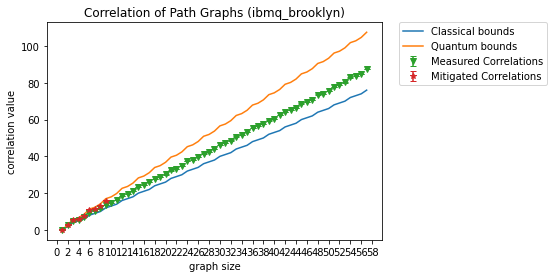

In [27]:
plot_correlations(max_size, 
                  c_bounds, 
                  q_bounds, 
                  [np.array(corr_list_real), np.array(tensored_corr_list_real)], 
                  [np.array(stddev_list_real), np.array(tensored_stddev_list_real)], 
                  ["Measured Correlations", "Mitigated Correlations"], 
                  ["v", "*"], 
                  "Correlation of Path Graphs (ibmq_brooklyn)")